In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import io, transform
import pickle, bz2
%matplotlib inline

# Experiment with convolutions using them directly

See

- [Up-sampling with Transposed Convolution](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0)
- [Types of convolution](https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d)
- [A guide to convolution arithmetic for deep learning](https://arxiv.org/abs/1603.07285)
- [Deconvolution and Checkerboard Artifacts](https://distill.pub/2016/deconv-checkerboard/)


**Convolution 2D*
![](Images/convolution2d.gif)   

**Convolution 2D Transposed**
![](Images/convolution2d-transposed.gif)

### 2d convolution

load an image and one filter

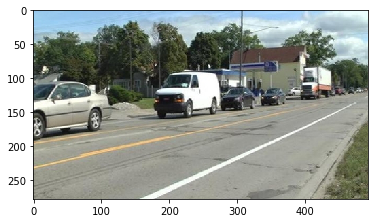

In [2]:
img = io.imread("Images/cars-driving.jpg")
plt.imshow(img)

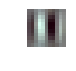

In [5]:
alex_c12 = pickle.load(bz2.BZ2File("data/alexnet_conv1_conv2.pklz", "r"), encoding="bytes")
filter_number = 90
akernel = alex_c12[b"conv1"][0][:,:,:,filter_number]
abias   = alex_c12[b"conv1"][1][filter_number]
plt.figure(figsize=(.7,.7))
plt.imshow((akernel-np.min(akernel))/(np.max(akernel)-np.min(akernel)))
plt.axis("off");

observe how we do one convolution, setting the initializers with the filter we just loaded

In [6]:
tf.reset_default_graph()
tX    = tf.placeholder(tf.float32, shape=[None] + list(img.shape), name="X")
layer = tf.layers.conv2d(tX, filters=1, kernel_size=[11,11], 
                         kernel_initializer=tf.initializers.constant(akernel),
                         bias_initializer=tf.initializers.constant(abias), 
                         activation="linear")
init  = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    output_img = sess.run(layer, feed_dict={tX: np.r_[[img]]})

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.


In [7]:
print(output_img.shape)

(1, 268, 483, 1)


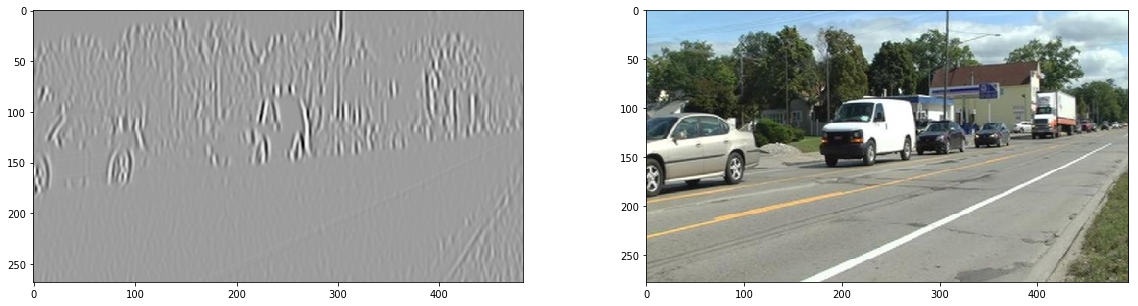

In [8]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(output_img[0,:,:,0], cmap=plt.cm.Greys_r)
plt.subplot(122)
plt.imshow(img)

observe how the layer internally creates TensorFlow variables

In [9]:
print("TF variables declared globally:")
print("\n".join([str(i) for i in layer.graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)]))

TF variables declared globally:
<tf.Variable 'conv2d/kernel:0' shape=(11, 11, 3, 1) dtype=float32_ref>
<tf.Variable 'conv2d/bias:0' shape=(1,) dtype=float32_ref>


### 1d convolution

observe how {`tf.layers.conv1d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv1d) internally creates two variables

In [10]:
tf.reset_default_graph()
tX    = tf.placeholder(tf.float32, shape=[None, 6, 1], name="X")
layer = tf.layers.conv1d(tX, filters=2, kernel_size=3, 
                         bias_initializer=tf.initializers.random_uniform([2]), 
                         activation="tanh")

init  = tf.global_variables_initializer()

Instructions for updating:
Use keras.layers.conv1d instead.


In [11]:
print("TF variables declared globally:")
print("\n".join([str(i) for i in layer.graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)]))

TF variables declared globally:
<tf.Variable 'conv1d/kernel:0' shape=(3, 1, 2) dtype=float32_ref>
<tf.Variable 'conv1d/bias:0' shape=(2,) dtype=float32_ref>


In [12]:
tkernel, tbias = layer.graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

In [13]:
tkernel.shape, tbias.shape

(TensorShape([Dimension(3), Dimension(1), Dimension(2)]),
 TensorShape([Dimension(2)]))

observe how TF initializes the kernel and bias differently each time a session is run

In [14]:
for _ in range(2):
    with tf.Session() as sess:
        sess.run(init)
        kernel, bias = sess.run([tkernel, tbias])
        print("kernel shape", kernel.shape, "bias shape", bias.shape)
        print("\n--", kernel)
        print("\n--", bias)
        print("\n")

kernel shape (3, 1, 2) bias shape (2,)

-- [[[ 0.7122774   0.631439  ]]

 [[-0.745846   -0.1699636 ]]

 [[ 0.01723552 -0.6395146 ]]]

-- [1.7175953 1.4778512]


kernel shape (3, 1, 2) bias shape (2,)

-- [[[ 0.2036463   0.3130033 ]]

 [[-0.2591467   0.24131083]]

 [[ 0.7706412   0.7827889 ]]]

-- [1.5260873 1.4547623]




### evaluating TensorFlow's convolution

first create a random input

In [15]:
size=7
X = np.random.randint(3, size=[size]+tX.shape.as_list()[1:])
X.shape

(7, 6, 1)

In [16]:
X.T

array([[[0, 1, 0, 1, 0, 2, 1],
        [0, 0, 0, 2, 1, 2, 0],
        [1, 2, 1, 2, 1, 1, 0],
        [0, 0, 1, 2, 2, 0, 1],
        [2, 0, 1, 0, 0, 2, 1],
        [1, 1, 0, 2, 2, 1, 2]]])

then feed it to the computational graph

In [17]:
with tf.Session() as sess:
    sess.run(init)
    output, kernel, bias = sess.run([layer, tkernel, tbias], feed_dict={tX: X})

In [18]:
print(X.shape)
print(kernel.shape)
print(bias.shape)
print(output.shape)

(7, 6, 1)
(3, 1, 2)
(2,)
(7, 4, 2)


In [19]:
print(output)

[[[ 0.97341126  0.84791535]
  [ 0.5382395   0.89249355]
  [ 0.98503906  0.9469791 ]
  [ 0.5398992   0.8288794 ]]

 [[ 0.98503906  0.9469791 ]
  [-0.1713698   0.88577855]
  [ 0.3826434   0.99512297]
  [ 0.97341126  0.84791535]]

 [[ 0.97341126  0.84791535]
  [ 0.8806743   0.8386533 ]
  [ 0.7124434   0.9631001 ]
  [ 0.11453278  0.9759564 ]]

 [[ 0.7135936   0.93993956]
  [ 0.38663012  0.98682404]
  [-0.8165413   0.99445724]
  [ 0.9608859   0.98840123]]

 [[ 0.8806743   0.8386533 ]
  [ 0.9314484   0.9435658 ]
  [-0.5781728   0.9743839 ]
  [ 0.9608859   0.98840123]]

 [[-0.3533434   0.99145067]
  [-0.35538897  0.9948006 ]
  [ 0.98503906  0.9469791 ]
  [ 0.5398992   0.8288794 ]]

 [[ 0.71128947  0.97743326]
  [ 0.97341126  0.84791535]
  [ 0.8806743   0.8386533 ]
  [ 0.9314484   0.9435658 ]]]


### doing the convolution by hand

the loop is for each convolution step

In [20]:
c = np.r_[[np.tanh(X[:,i:i+kernel.shape[0],0].dot(kernel[:,0,:])+bias) \
            for i in range(X.shape[1]-kernel.shape[0]+1)]].swapaxes(0,1).reshape(output.shape)
c

array([[[ 0.97341127,  0.84791532],
        [ 0.53823944,  0.89249351],
        [ 0.98503891,  0.94697905],
        [ 0.53989912,  0.82887935]],

       [[ 0.98503891,  0.94697905],
        [-0.17136981,  0.88577848],
        [ 0.3826434 ,  0.99512294],
        [ 0.97341127,  0.84791532]],

       [[ 0.97341127,  0.84791532],
        [ 0.8806743 ,  0.83865325],
        [ 0.7124434 ,  0.96310007],
        [ 0.11453284,  0.97595635]],

       [[ 0.71359353,  0.93993957],
        [ 0.38663023,  0.98682404],
        [-0.81654119,  0.99445722],
        [ 0.96088591,  0.9884012 ]],

       [[ 0.8806743 ,  0.83865325],
        [ 0.93144838,  0.94356579],
        [-0.5781728 ,  0.97438398],
        [ 0.96088591,  0.9884012 ]],

       [[-0.35334329,  0.99145066],
        [-0.35538904,  0.99480069],
        [ 0.98503891,  0.94697905],
        [ 0.53989912,  0.82887935]],

       [[ 0.71128943,  0.97743331],
        [ 0.97341127,  0.84791532],
        [ 0.8806743 ,  0.83865325],
        [ 0.9314

In [21]:
np.allclose(output, c)

True

### using a convolution matrix

the filter is transformed into a matrix so that when doing matrix multiplication with the original input, the result contains the elements obtained through a sequential convolution.

In [22]:
def get_conv_matrix(input_shape, kernel):
     return np.r_[[[0]*i+list(kernel)+[0]*(input_shape[1]-kernel.shape[0]-i) \
                   for i in range(input_shape[1]-kernel.shape[0]+1)]]

convolution matrix for the first filter

In [23]:
cm = get_conv_matrix(X.shape,kernel[:,0,1])
print(cm.shape)
cm.T

(4, 6)


array([[ 0.77041876,  0.        ,  0.        ,  0.        ],
       [-0.03207153,  0.77041876,  0.        ,  0.        ],
       [-0.21743321, -0.03207153,  0.77041876,  0.        ],
       [ 0.        , -0.21743321, -0.03207153,  0.77041876],
       [ 0.        ,  0.        , -0.21743321, -0.03207153],
       [ 0.        ,  0.        ,  0.        , -0.21743321]])

In [24]:
X.shape

(7, 6, 1)

In [25]:
np.tanh(X[:,:,0].dot(cm.T)+bias[0])

array([[0.82071101, 0.87271391, 0.93688969, 0.798641  ],
       [0.93688969, 0.86485165, 0.99416743, 0.82071101],
       [0.82071101, 0.80996256, 0.95600906, 0.9712998 ],
       [0.92855982, 0.98425547, 0.99337173, 0.98613794],
       [0.80996256, 0.93284932, 0.96942762, 0.98613794],
       [0.98977939, 0.99378226, 0.93688969, 0.798641  ],
       [0.9730589 , 0.82071101, 0.80996256, 0.93284932]])

and for all the filters together

In [26]:
c = np.r_[[np.tanh(X[:,:,0].dot(get_conv_matrix(X.shape, kernel[:,0,i]).T)+bias[i]).T \
          for i in range(kernel.shape[-1])]].swapaxes(2,0).reshape(output.shape)
c

array([[[ 0.97341127,  0.84791532],
        [ 0.53823944,  0.89249351],
        [ 0.98503891,  0.94697905],
        [ 0.53989912,  0.82887935]],

       [[ 0.98503891,  0.94697905],
        [-0.17136981,  0.88577848],
        [ 0.3826434 ,  0.99512294],
        [ 0.97341127,  0.84791532]],

       [[ 0.97341127,  0.84791532],
        [ 0.8806743 ,  0.83865325],
        [ 0.7124434 ,  0.96310007],
        [ 0.11453284,  0.97595635]],

       [[ 0.71359353,  0.93993957],
        [ 0.38663023,  0.98682404],
        [-0.81654119,  0.99445722],
        [ 0.96088591,  0.9884012 ]],

       [[ 0.8806743 ,  0.83865325],
        [ 0.93144838,  0.94356579],
        [-0.5781728 ,  0.97438398],
        [ 0.96088591,  0.9884012 ]],

       [[-0.35334329,  0.99145066],
        [-0.35538904,  0.99480069],
        [ 0.98503891,  0.94697905],
        [ 0.53989912,  0.82887935]],

       [[ 0.71128943,  0.97743331],
        [ 0.97341127,  0.84791532],
        [ 0.8806743 ,  0.83865325],
        [ 0.9314

In [27]:
np.allclose(c, output)

True

### transposed convolution

In [28]:
cm = get_conv_matrix(X.shape,kernel[:,0,1])

direct convolution

In [29]:
np.tanh(X[:,:,0].dot(cm.T)+bias[0])

array([[0.82071101, 0.87271391, 0.93688969, 0.798641  ],
       [0.93688969, 0.86485165, 0.99416743, 0.82071101],
       [0.82071101, 0.80996256, 0.95600906, 0.9712998 ],
       [0.92855982, 0.98425547, 0.99337173, 0.98613794],
       [0.80996256, 0.93284932, 0.96942762, 0.98613794],
       [0.98977939, 0.99378226, 0.93688969, 0.798641  ],
       [0.9730589 , 0.82071101, 0.80996256, 0.93284932]])

In [30]:
output.shape, X.shape, cm.shape

((7, 4, 2), (7, 6, 1), (4, 6))

transposed convolution. It recovers the **shape** of the original input (not the content)

In [31]:
tc = output[:,:,0].dot(cm).reshape(X.shape)
tc.T

array([[[ 0.7499343 ,  0.75889257,  0.7499343 ,  0.5497659 ,
          0.67848801, -0.27222238,  0.54799075],
        [ 0.383451  , -0.16361822,  0.64726922,  0.27498106,
          0.68936075, -0.26246607,  0.72712216],
        [ 0.52997847,  0.08611154,  0.30898326, -0.79663752,
         -0.666796  ,  0.84711903,  0.49261126],
        [ 0.2673256 ,  0.77492383, -0.1260988 ,  0.68240601,
          0.55629958,  0.46163011,  0.47770881],
        [-0.2314956 , -0.11441817, -0.1585821 ,  0.14672612,
          0.09489689, -0.2314956 , -0.22136082],
        [-0.11739201, -0.21165194, -0.02490323, -0.20892851,
         -0.20892851, -0.11739201, -0.20252782]]])

In [32]:
X.T

array([[[0, 1, 0, 1, 0, 2, 1],
        [0, 0, 0, 2, 1, 2, 0],
        [1, 2, 1, 2, 1, 1, 0],
        [0, 0, 1, 2, 2, 0, 1],
        [2, 0, 1, 0, 0, 2, 1],
        [1, 1, 0, 2, 2, 1, 2]]])

In [33]:
X.shape, tc.shape

((7, 6, 1), (7, 6, 1))